# Ablation 1 : No self-training (evaluate just the initial weakly supervised model)



## Final Project

Team 140: Anson Wong & Skyler MacAdam

GitHub link: https://github.com/skylernovak/KeyClass/tree/main

For our final project, we have selected the paper [Classifying Unstructured Clinical Notes via Automatic Weak Supervision](https://arxiv.org/pdf/2206.12088.pdf). We will attempt to reproduce their study with similar results.

This is our first ablation from our reproduction of the KeyClass research paper. For additional context and information about the base approach and model, please see the primary notebook.

https://colab.research.google.com/drive/1ga1r8yUizxmBm_6Kpg1e-UyrPjQFXhjx?usp=sharing

# Mount Notebook to Google Drive

This step needs to be completed the first time when Google Colab is opened and you are starting a new session.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Methodology

Here, we begin our implementation of our study. Below you will find two sections, Data and Model.

### Data

This section we will load and pre-process our data for our experiements.

### Model

This section we will construct the model used for the experiment.

In [ ]:
# Run this cell to install all requirements for this project.
%cd /content/drive/My Drive/CS598FinalProject/
%ls
!pip install -r requirements.txt

/content/drive/My Drive/CS598FinalProject
config_files/                       end_model_preds_test_self_training.npy  results/
data/                               end_model_preds_train_key_class.npy     scripts/
DL4H_Team_140                       keyclass/                               y_test.npy
DL4H_Team_140_Ablation              models/                                 y_train_lm_masked.npy
end_model_preds_test_key_class.npy  requirements.txt                        y_train_masked.npy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 57.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using

In [ ]:
# Run this cell to import the remaining modules needed for this experiment.
%cd /content/drive/My Drive/CS598FinalProject/keyclass/
%ls

# Append paths for imports.
import sys
sys.path.append('/content/drive/My Drive/CS598FinalProject/keyclass/')
sys.path.append('/content/drive/My Drive/CS598FinalProject/scripts/')

# Import files and modules needed for KeyClass
import numpy as np
import utils
import models
import create_lfs
import train_classifier
import torch
import pickle
from os.path import join, exists
import pandas as pd
import os
import train_downstream_model

/content/drive/My Drive/CS598FinalProject/keyclass
create_lfs.py  __init__.py  models.py  __pycache__/  train_classifier.py  utils.py


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##  Data

### Source of the data

The data used in the paper is collected from 4 different datasets. Amazon, DBpedia, IMDB, and AG News. The authors collected this data and included a script with their paper to download copies of these datasets as well for others to reproduce the authors findings. We downloaded this data and included it within out google drive as well. These scripts are downloaded using the script `get_data.sh`.

These 4 datasets are used in common multiclass text classification problems, such as in movie review sentiments from IMBD.

### Statistics

Utilizing the IMDB dataset, the paper attempts to classify movie reviews as either `positive` or `negative`. The KeyClass model was provided with common sense descriptions for these classes from industry experts. This constitutes minimal human input required for KeyClass to perform the classifications. For example, a positive review is typically assocaited with words such as "amazing", "exciting", or "fun" while negative reviews are more often associated with words such as "terrible", "boring", or "awful".

Both the `train` and `test` datasets contains 25000 sample movie reviews each. KeyClass attempts to label each review as either `positive` or `negative` based on these reviews. Each data split contains approximately 32 million characters, and the files are approximately 30 MB each.  

### Data process

The KeyClass framework consists of several key steps:

1. Finding relevant keywords and phrases from the class descriptions using a pre-trained language model (such as BERT).
1. Constructing labeling functions based on the identified keywords and using data programming to generate probabilistic labels for the training data.
1. Training a downstream classifier on the probabilistically labeled training data.
1. Self-training the downstream model on the entire training dataset to refine the classifier.

In [ ]:
# Declare configuration variables
config_file_path = r'/content/drive/My Drive/CS598FinalProject/config_files/config_imdb.yml' # Specify path to the configuration file
random_seed = 0 # Random seed for experiments
args = utils.Parser(config_file_path=config_file_path).parse()

The following block of code processes the text and creates embeddings. It is highly encouraged to use the Google Colab t4 GPU runtime type to execute this block of code. Using the T4 GPU, this takes a couple of minutes to execute. Using the CPU runtime type, this can take hours.

This block of code has been commented out as the embeddings have been saved in pickle files for later use in this notebook. This step is not required to be executed again, and is left here for informational / demonstrative purposes.

In [ ]:
# args = utils.Parser(config_file_path=config_file_path).parse()

# if args['use_custom_encoder']:
#     model = models.CustomEncoder(pretrained_model_name_or_path=args['base_encoder'],
#         device='cuda' if torch.cuda.is_available() else 'cpu')
# else:
#     model = models.Encoder(model_name=args['base_encoder'],
#         device='cuda' if torch.cuda.is_available() else 'cpu')

# for split in ['train', 'test']:
#     sentences = utils.fetch_data(dataset=args['dataset'], split=split, path=args['data_path'])
#     embeddings = model.encode(sentences=sentences, batch_size=args['end_model_batch_size'],
#                                 show_progress_bar=args['show_progress_bar'],
#                                 normalize_embeddings=args['normalize_embeddings'])
#     with open(join(args['data_path'], args['dataset'], f'{split}_embeddings.pkl'), 'wb') as f:
#         pickle.dump(embeddings, f)

Here we now load the training data, and then create the labeling function. Finally we create the probablistic labels from the training document.

In [ ]:
# Load training data
train_text = utils.fetch_data(dataset=args['dataset'], path=args['data_path'], split='train')

training_labels_present = False
if exists(join(args['data_path'], args['dataset'], 'train_labels.txt')):
    with open(join(args['data_path'], args['dataset'], 'train_labels.txt'), 'r') as f:
        y_train = f.readlines()
    y_train = np.array([int(i.replace('\n','')) for i in y_train])
    training_labels_present = True
else:
    y_train = None
    training_labels_present = False
    print('No training labels found!')

with open(join(args['data_path'], args['dataset'], 'train_embeddings.pkl'), 'rb') as f:
    X_train = pickle.load(f)

# Print dataset statistics
print(f"Getting labels for the {args['dataset']} data...")
print(f'Size of the data: {len(train_text)}')
if training_labels_present:
    print('Class distribution', np.unique(y_train, return_counts=True))

# Load label names/descriptions
label_names = []
for a in args:
    if 'target' in a: label_names.append(args[a])

# Creating labeling functions
labeler = create_lfs.CreateLabellingFunctions(base_encoder=args['base_encoder'],
                                            device=torch.device(args['device']),
                                            label_model=args['label_model'])
proba_preds = labeler.get_labels(text_corpus=train_text, label_names=label_names, min_df=args['min_df'],
                                ngram_range=args['ngram_range'], topk=args['topk'], y_train=y_train,
                                label_model_lr=args['label_model_lr'], label_model_n_epochs=args['label_model_n_epochs'],
                                verbose=True, n_classes=args['n_classes'])

y_train_pred = np.argmax(proba_preds, axis=1)

# Save the predictions
if not os.path.exists(args['preds_path']): os.makedirs(args['preds_path'])
with open(join(args['preds_path'], f"{args['label_model']}_proba_preds.pkl"), 'wb') as f:
    pickle.dump(proba_preds, f)

# Print statistics
print('Label Model Predictions: Unique value and counts', np.unique(y_train_pred, return_counts=True))
if training_labels_present:
    print('Label Model Training Accuracy', np.mean(y_train_pred==y_train))

    # Log the metrics
    training_metrics_with_gt = utils.compute_metrics(y_preds=y_train_pred, y_true=y_train, average=args['average'])
    utils.log(metrics=training_metrics_with_gt, filename='label_model_with_ground_truth',
        results_dir=args['results_path'], split='train')

Getting labels for the imdb data...
Size of the data: 25000
Class distribution (array([0, 1]), array([12500, 12500]))


.gitattributes:   0%|          | 0.00/744 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Found assigned category counts [6789 9578]
labeler.vocabulary:
 16367
labeler.word_indicator_matrix.shape (25000, 600)
Len keywords 600
assigned_category: Unique and Counts (array([0, 1]), array([300, 300]))
negative, hate, expensive, bad, poor, broke, waste, horrible, would not recommend ['abominable' 'abomination' 'absolute worst' 'absolutely awful'
 'absolutely terrible' 'abuse' 'abused' 'abusive' 'abysmal'
 'acting horrible' 'acting poor' 'acting terrible' 'actors bad'
 'actually bad' 'also bad' 'among worst' 'annoyance' 'annoying' 'appalled'
 'appalling' 'atrocious' 'awful' 'awfully' 'awfulness' 'bad' 'bad actor'
 'bad actors' 'bad actually' 'bad almost' 'bad bad' 'bad could'
 'bad either' 'bad enough' 'bad even' 'bad film' 'bad films' 'bad get'
 'bad horror' 'bad idea' 'bad like' 'bad made' 'bad makes' 'bad many'
 'bad movie' 'bad movies' 'bad music' 'bad one' 'bad ones' 'bad people'
 'bad really' 'bad reviews' 'bad special' 'bad story' 'bad taste'
 'bad thing' 'bad things' 'bad 

100%|██████████| 100/100 [00:08<00:00, 11.33epoch/s]


Label Model Predictions: Unique value and counts (array([0, 1]), array([ 8914, 16086]))
Label Model Training Accuracy 0.70016
Saving results in ../results/imdb/train_label_model_with_ground_truth_26-Apr-2024-23_21_25.txt...


### Train the Downstream Model

#### Find Class Descriptions

KeyClass starts with just the class descriptions (e.g., "positive review" and "negative review") without any labeled training data.

#### Find Relevant Keywords

Using the class descriptions and a pre-trained language model (like BERT), KeyClass automatically extracts keywords and phrases that are highly indicative of each class.
#### Probabilistically Label the Data

KeyClass uses the extracted keywords as labeling functions and applies data programming techniques to generate probabilistic labels for the entire training dataset.

#### Train Downstream Model

KeyClass then trains a downstream text classification model (e.g., a feed-forward neural network) using the probabilistically labeled training data. It initially only uses the most confidently labeled samples to train the model.


The key advantages of this approach are that it requires no manually labeled training data and the labeling functions are automatically generated in an interpretable way.

In [ ]:
args = utils.Parser(config_file_path=config_file_path).parse()

# Set random seeds
random_seed = random_seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train_embed_masked, y_train_lm_masked, y_train_masked, \
	X_test_embed, y_test, training_labels_present, \
	sample_weights_masked, proba_preds_masked = train_downstream_model.load_data(args)

# Train a downstream classifier

if args['use_custom_encoder']:
	encoder = models.CustomEncoder(pretrained_model_name_or_path=args['base_encoder'], device=args['device'])
else:
	encoder = models.Encoder(model_name=args['base_encoder'], device=args['device'])

classifier = models.FeedForwardFlexible(encoder_model=encoder,
										h_sizes=args['h_sizes'],
										activation=eval(args['activation']),
										device=torch.device(args['device']))
print('\n===== Training the downstream classifier =====\n')
model = train_classifier.train(model=classifier,
							device=torch.device(args['device']),
							X_train=X_train_embed_masked,
							y_train=y_train_lm_masked,
							sample_weights=sample_weights_masked if args['use_noise_aware_loss'] else None,
							epochs=args['end_model_epochs'],
							batch_size=args['end_model_batch_size'],
							criterion=eval(args['criterion']),
							raw_text=False,
							lr=eval(args['end_model_lr']),
							weight_decay=eval(args['end_model_weight_decay']),
							patience=args['end_model_patience'])


end_model_preds_train = model.predict_proba(torch.from_numpy(X_train_embed_masked), batch_size=512, raw_text=False)
end_model_preds_test = model.predict_proba(torch.from_numpy(X_test_embed), batch_size=512, raw_text=False)

Confidence of least confident data point of class 0: 0.9118951704039087
Confidence of least confident data point of class 1: 0.9999157389338196

==== Data statistics ====
Size of training data: (25000, 768), testing data: (25000, 768)
Size of testing labels: (25000,)
Size of training labels: (25000,)
Training class distribution (ground truth): [0.5 0.5]
Training class distribution (label model predictions): [0.35656 0.64344]

KeyClass only trains on the most confidently labeled data points! Applying mask...

==== Data statistics (after applying mask) ====
Size of training data: (7000, 768)
Size of training labels: (7000,)
Training class distribution (ground truth): [0.55057143 0.44942857]
Training class distribution (label model predictions): [0.5 0.5]

===== Training the downstream classifier =====



Epoch 18:  90%|█████████ | 18/20 [00:05<00:00,  3.55batch/s, best_loss=0.546, running_loss=0.548, tolerance_count=3]

Stopping early...


### ABLATION

No self-training (evaluate just the initial weakly supervised model)

To evaluate the performance of the initial weakly supervised model without self-training, I remove the code block that performs self-training.

In [ ]:
# # Fetching the raw text data for self-training
# X_train_text = utils.fetch_data(dataset=args['dataset'], path=args['data_path'], split='train')
# X_test_text = utils.fetch_data(dataset=args['dataset'], path=args['data_path'], split='test')

# model = train_classifier.self_train(model=model,
# 									X_train=X_train_text,
# 									X_val=X_test_text,
# 									y_val=y_test,
# 									device=torch.device(args['device']),
# 									lr=eval(args['self_train_lr']),
# 									weight_decay=eval(args['self_train_weight_decay']),
# 									patience=args['self_train_patience'],
# 									batch_size=args['self_train_batch_size'],
# 									q_update_interval=args['q_update_interval'],
# 									self_train_thresh=eval(args['self_train_thresh']),
# 									print_eval=True)


# end_model_preds_test = model.predict_proba(X_test_text, batch_size=args['self_train_batch_size'], raw_text=True)


# # Print statistics
# testing_metrics = utils.compute_metrics_bootstrap(y_preds=np.argmax(end_model_preds_test, axis=1),
# 													y_true=y_test,
# 													average=args['average'],
# 													n_bootstrap=args['n_bootstrap'],
# 													n_jobs=args['n_jobs'])
# print(testing_metrics)

## After training the downstream classifier and (and skipping self-training), the notebook performs the following evaluation steps:

1. Load Test Data: It loads the test dataset, including the test text samples (X_test_embed) and the ground truth test labels (y_test).
1. Evaluate Trained Model on Test Set: It uses the trained downstream model to make predictions on the test set, obtaining the test set predictions (end_model_preds_test).
1. Compute Test Metrics: It computes various performance metrics on the test set predictions, including:

**Metrics using ground truth labels (y_test):** Compute metrics using utils.compute_metrics_bootstrap(), which does bootstrap sampling to get confidence intervals. This provides an assessment of the model's true performance on the test set.

**Metrics using label model predictions (y_train_lm_masked):** Compute metrics using utils.compute_metrics(). This shows how the model performs compared to the noisy labels used for training.

**Print Test Metrics:** The notebook prints out the test set performance metrics, showing the model's accuracy, precision, recall, and F1-score.

**Self-Train the Model:** Finally, it loads the self-trained model checkpoint and evaluates the self-trained model on the test set, printing the updated test set performance metrics.

In [ ]:
# end_model_path='/content/drive/My Drive/CS598FinalProject/models/end_model.pth'
# end_model_self_trained_path='/content/drive/My Drive/CS598FinalProject/models/end_model_self_trained.pth'

args = utils.Parser(config_file_path=config_file_path).parse()

# Set random seeds
random_seed = random_seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train_embed_masked, y_train_lm_masked, y_train_masked, \
	X_test_embed, y_test, training_labels_present, \
	sample_weights_masked, proba_preds_masked = train_downstream_model.load_data(args)

# model = torch.load(end_model_path)

end_model_preds_train_key_class = model.predict_proba(torch.from_numpy(X_train_embed_masked), batch_size=512, raw_text=False)
end_model_preds_test_key_class = model.predict_proba(torch.from_numpy(X_test_embed), batch_size=512, raw_text=False)

# Print statistics
if training_labels_present:
	training_metrics_with_gt = utils.compute_metrics(y_preds=np.argmax(end_model_preds_train_key_class, axis=1),
														y_true=y_train_masked,
														average=args['average'])
	print('training_metrics_with_gt', training_metrics_with_gt)

training_metrics_with_lm = utils.compute_metrics(y_preds=np.argmax(end_model_preds_train_key_class, axis=1),
													y_true=y_train_lm_masked,
													average=args['average'])
print('training_metrics_with_lm', training_metrics_with_lm)

testing_metrics = utils.compute_metrics_bootstrap(y_preds=np.argmax(end_model_preds_test_key_class, axis=1),
													y_true=y_test,
													average=args['average'],
													n_bootstrap=args['n_bootstrap'],
													n_jobs=args['n_jobs'])
print('testing_metrics', testing_metrics)


print('\n===== Self-training the downstream classifier =====\n')

# Fetching the raw text data for self-training
X_train_text = utils.fetch_data(dataset=args['dataset'], path=args['data_path'], split='train')
X_test_text = utils.fetch_data(dataset=args['dataset'], path=args['data_path'], split='test')

# model = torch.load(end_model_self_trained_path)

end_model_preds_test_self_training = model.predict_proba(X_test_text, batch_size=args['self_train_batch_size'], raw_text=True)


# Print statistics
testing_metrics = utils.compute_metrics_bootstrap(y_preds=np.argmax(end_model_preds_test_self_training, axis=1),
													y_true=y_test,
													average=args['average'],
													n_bootstrap=args['n_bootstrap'],
													n_jobs=args['n_jobs'])
print('testing_metrics after self train', testing_metrics)

Confidence of least confident data point of class 0: 0.9118951704039087
Confidence of least confident data point of class 1: 0.9999157389338196

==== Data statistics ====
Size of training data: (25000, 768), testing data: (25000, 768)
Size of testing labels: (25000,)
Size of training labels: (25000,)
Training class distribution (ground truth): [0.5 0.5]
Training class distribution (label model predictions): [0.35656 0.64344]

KeyClass only trains on the most confidently labeled data points! Applying mask...

==== Data statistics (after applying mask) ====
Size of training data: (7000, 768)
Size of training labels: (7000,)
Training class distribution (ground truth): [0.55057143 0.44942857]
Training class distribution (label model predictions): [0.5 0.5]
training_metrics_with_gt [0.9204285714285714, 0.9241398875739136, 0.9204285714285714]
training_metrics_with_lm [0.9218571428571428, 0.9219690593856281, 0.9218571428571428]


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.8s finished


testing_metrics [[0.8491612  0.00204014]
 [0.86128409 0.00184495]
 [0.8491612  0.00204014]]

===== Self-training the downstream classifier =====



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   17.0s


testing_metrics after self train [[0.8495204  0.00235398]
 [0.8615633  0.00208607]
 [0.8495204  0.00235398]]


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   20.5s finished


# Save Ablations Result

No self-training (evaluate just the initial weakly supervised model)


In [ ]:
# File paths for saving the arrays
save_paths = {
    'y_test_ablation_1': '/content/drive/My Drive/CS598FinalProject/y_test_ablation_1.npy',
    'y_train_masked_ablation_1': '/content/drive/My Drive/CS598FinalProject/y_train_masked_ablation_1.npy',
    'y_train_lm_masked_ablation_1': '/content/drive/My Drive/CS598FinalProject/y_train_lm_masked_ablation_1.npy',
    'end_model_preds_train_key_class_ablation_1': '/content/drive/My Drive/CS598FinalProject/end_model_preds_train_key_class_ablation_1.npy',
    'end_model_preds_test_key_class_ablation_1': '/content/drive/My Drive/CS598FinalProject/end_model_preds_test_key_class_ablation_1.npy',
    'end_model_preds_test_self_training_ablation_1': '/content/drive/My Drive/CS598FinalProject/end_model_preds_test_self_training_ablation_1.npy'
}

# Arrays to save
arrays_to_save = {
    'y_test_ablation_1': y_test,
    'y_train_masked_ablation_1': y_train_masked,
    'y_train_lm_masked_ablation_1': y_train_lm_masked,
    'end_model_preds_train_key_class_ablation_1': end_model_preds_train_key_class,
    'end_model_preds_test_key_class_ablation_1': end_model_preds_test_key_class,
    'end_model_preds_test_self_training_ablation_1': end_model_preds_test_self_training
}

# Save arrays
for name, array in arrays_to_save.items():
    np.save(save_paths[name], array)

# Load Ablation Results


In [ ]:
file_path = '/content/drive/My Drive/CS598FinalProject/y_test_ablation_1.npy'
y_test_ablation_1 = np.load(file_path)

In [ ]:
file_path = '/content/drive/My Drive/CS598FinalProject/y_train_masked_ablation_1.npy'
y_train_masked_ablation_1 = np.load(file_path)

In [ ]:
file_path = '/content/drive/My Drive/CS598FinalProject/y_train_lm_masked_ablation_1.npy'
y_train_lm_masked_ablation_1 = np.load(file_path)

In [ ]:
file_path = '/content/drive/My Drive/CS598FinalProject/end_model_preds_train_key_class_ablation_1.npy'
end_model_preds_train_key_class_ablation_1 = np.load(file_path)

In [ ]:
file_path = '/content/drive/My Drive/CS598FinalProject/end_model_preds_test_key_class_ablation_1.npy'
end_model_preds_test_key_class_ablation_1 = np.load(file_path)

In [ ]:
file_path = '/content/drive/My Drive/CS598FinalProject/end_model_preds_test_self_training_ablation_1.npy'
end_model_preds_test_self_training_ablation_1 = np.load(file_path)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# weak supervision sources (keywords and phrases) results

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import seaborn as sns

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot precision-recall curve
def plot_precision_recall_curve(y_true, y_score, title):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()


# Plot histogram of predicted probabilities
def plot_predicted_probabilities_histogram(y_prob):
    plt.hist(y_prob, bins=10)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Probabilities')
    plt.show()


# Example usage
y_preds_ablation_1=np.argmax(end_model_preds_train_key_class_ablation_1, axis=1)

# plot_predicted_probabilities_histogram(end_model_preds_train_key_class)
# plot_probabilistic_vs_predicted_labels(y_train_lm_masked, y_preds)


# Ablation 1 result: The following evaluates how well the model learns from ground truth labels (y_train_masked) and the label model predictions (y_train_lm_masked)

**Confusion Matrix:** The confusion matrix showcases how accurately the model predicts the true labels compared to the ground truth.
It highlights the model's performance in terms of correctly identifying positive and negative instances and any misclassifications.

**Precision-Recall Curve:** The precision-recall curve demonstrates the trade-off between precision and recall for different decision thresholds.
It quantifies how well the model identifies positive instances while minimizing false positives and negatives compared to the ground truth.

**ROC Curve:** The ROC curve illustrates the model's ability to distinguish between positive and negative instances across various decision thresholds.
It measures the model's true positive rate and false positive rate compared to the ground truth.

---

Overall, these comparisons of the plots between Ground Truth vs. Predicted Labels and KeyClass Labels vs. Predicted Labels are similar. It showcased the high performance of keyclass low supervised labeling.

Confusion Matrix reveal how well the model is able to learn from the keyclass probabilistic labels compared to the true labels.

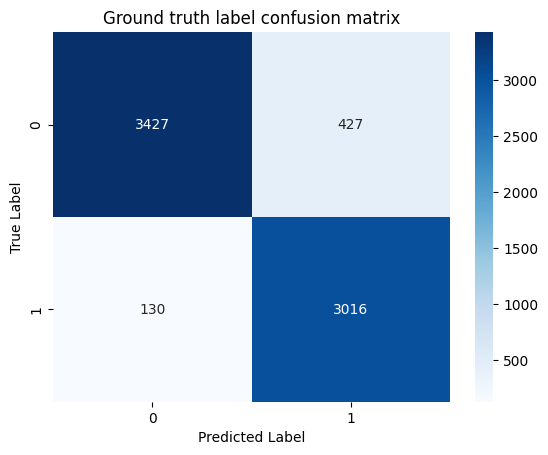

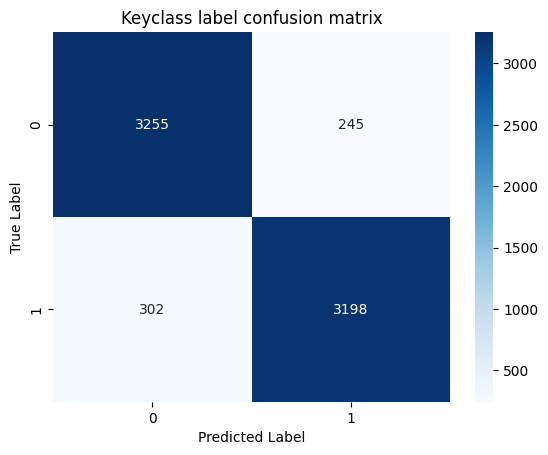

In [ ]:
plot_confusion_matrix(y_train_masked_ablation_1, y_preds_ablation_1, 'Ground truth label confusion matrix')
plot_confusion_matrix(y_train_lm_masked_ablation_1, y_preds_ablation_1, 'Keyclass label confusion matrix')

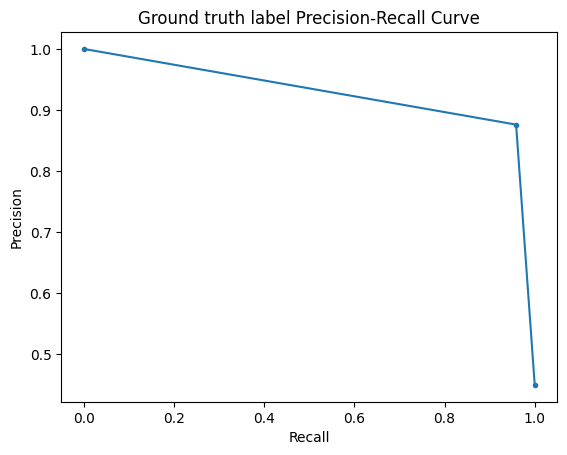

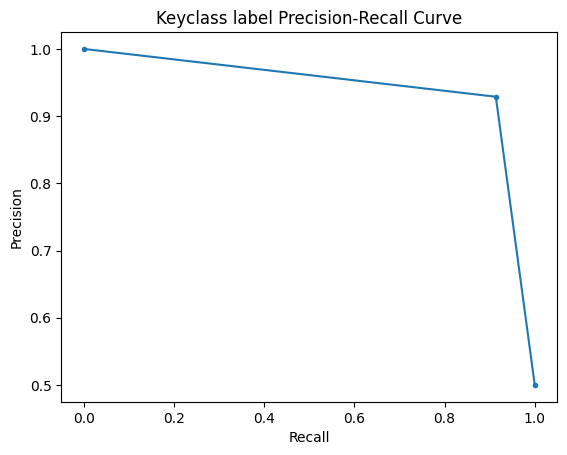

In [ ]:
plot_precision_recall_curve(y_train_masked_ablation_1, y_preds_ablation_1, 'Ground truth label Precision-Recall Curve')
plot_precision_recall_curve(y_train_lm_masked_ablation_1, y_preds_ablation_1, 'Keyclass label Precision-Recall Curve')

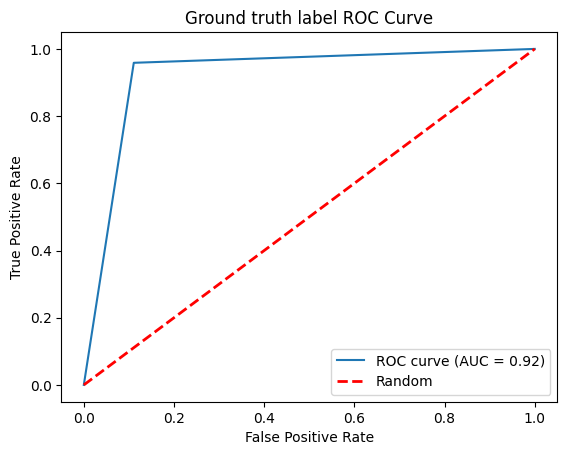

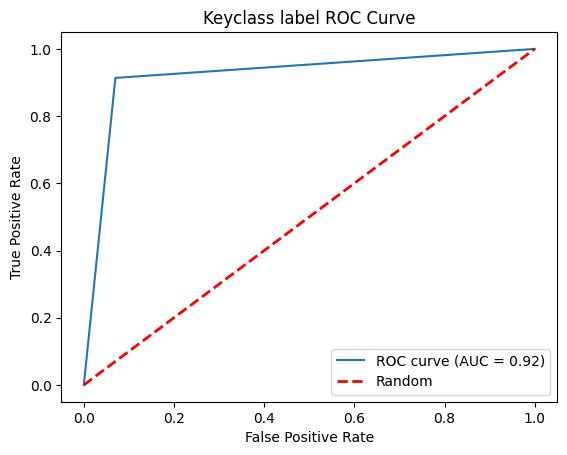

In [ ]:
plot_roc_curve(y_train_masked_ablation_1, y_preds_ablation_1, 'Ground truth label ROC Curve')
plot_roc_curve(y_train_lm_masked_ablation_1, y_preds_ablation_1, 'Keyclass label ROC Curve')

# Discussion

Ablation 1 removes self-training and has lower accuracy, confusion matrix number, a really close precision-recall and ROC curve.From the confidence intervals (CIs) we can compare the result is a bit lower than the original result.

## Lower Mean

A lower mean value suggests that, on average, the performance metrics (such as accuracy, precision, recall, etc.) obtained from the bootstrap samples are lower. This could imply that the model's performance is consistently lower across different subsets of the data.

## Lower Standard Deviation (std)

A lower standard deviation indicates less variability or spread in the performance metrics across different bootstrap samples. In other words, the estimates of the performance metrics are more consistent and less scattered around the mean. This suggests that the performance of the model is relatively stable and less sensitive to variations in the data.

```
#Left column is mean,
Ablation_1_testing_metrics:
[[0.8491612  0.00204014]
 [0.86128409 0.00184495]
 [0.8491612  0.00204014]]

Original_testing_metrics
 [[0.8533216  0.00209534]
 [0.86366085 0.00188531]
 [0.8533216  0.00209534]]
```



